In [30]:

import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_triband_filter_design, make_reflection_design, get_minus_filter_spec

from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 1
batch_size = None
max_steps=1000
show = True


def exp(n_size, each_ot, target):
    np.random.seed()
    init_n = np.zeros(n_size) + 2
    film = EqOTFilm(init_n, each_ot * n_size, substrate=1.5)

    adam_optimizer = AdamFreeFormOptimizer(
        film, 
        target, 
        max_steps=max_steps, 
        alpha=alpha * 1e2 / (n_size * each_ot), # 0.01 for big OT films...
        record=True, 
        show=show, 
        n_min=n_min, # 1.5
        n_max=n_max, # 2.5
        wl_batch_size=batch_size # full 
    )

    adam_optimizer.optimize()
    return calculate_RMS_f_spec(film, target), film


# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

# target = make_triband_filter_design().target_specs # 1 / wl_max - 1 / wl_min = 
wls = np.linspace(400., 700., 500)
target = [get_minus_filter_spec(wls)]
target_name = 'minus_filter'

In [ ]:
# test
loss, film = exp(1000, 1000, target) # this is sufficient for spectrum under-sampling

Text(0.5, 0, 'wl')

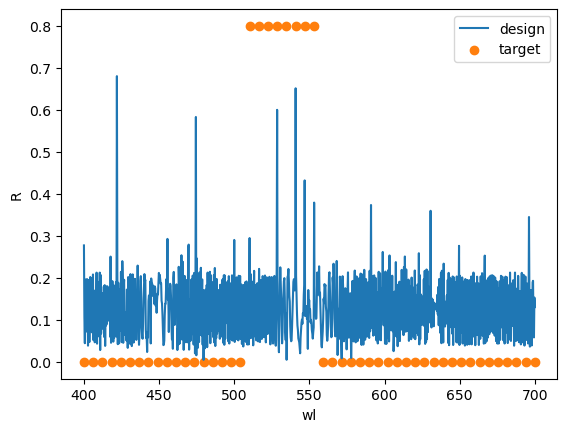

In [19]:
wls_dense = np.linspace(wls[0], wls[-1], 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(wls_dense, film.get_spec(0., wls_dense).get_R(), label='design')
ax.scatter(wls, target[0].get_R(), label='target', c='C1')

ax.legend()
ax.set_ylabel('R')
ax.set_xlabel('wl')

In [ ]:
each_ots = np.array([i for i in 10 ** np.linspace(-1, 3, 50)])
n_sizes = np.array([int(i) for i in 10 ** np.linspace(0, 3, 50)])


films_arr_rep, best_loss_arr_rep, best_film_arr_rep = [], [], []
for rep in range(reps):
    films_arr_rep.append([])
    best_loss_arr_rep.append([])
    best_film_arr_rep.append([])
    for i, ot in enumerate(each_ots):
        films_arr_rep[-1].append([])
        best_loss_arr_rep[-1].append([])
        best_film_arr_rep[-1].append([])
        for j, n_size in enumerate(n_sizes):
            print((i + j / n_sizes.shape[0]) / each_ots.shape[0])
            best_loss, best_film = exp(n_size, ot, target)
            best_film.remove_all_spec_param() # save storage
            films_arr_rep[-1][-1].append([])
            best_loss_arr_rep[-1][-1].append(best_loss)
            best_film_arr_rep[-1][-1].append(best_film)
print(best_loss_arr_rep)

save(f'./raw_result_total_ot/free_form_params_{target_name}_target_sparse', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))